In [36]:
import pandas as pd
import pdpipe as pdp

In [2]:
data = pd.read_csv('training.csv')
df = data.iloc[:, 1:10]
df.shape

(72983, 9)

In [3]:
df.head()

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel
0,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I
1,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT
2,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV
3,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN
4,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   IsBadBuy    72983 non-null  int64 
 1   PurchDate   72983 non-null  object
 2   Auction     72983 non-null  object
 3   VehYear     72983 non-null  int64 
 4   VehicleAge  72983 non-null  int64 
 5   Make        72983 non-null  object
 6   Model       72983 non-null  object
 7   Trim        70623 non-null  object
 8   SubModel    72975 non-null  object
dtypes: int64(3), object(6)
memory usage: 5.0+ MB


# Data Exploration

## PurchDate

Data zakupu samochodu na aukcji

In [5]:
df['PurchDate'] = pd.to_datetime(df['PurchDate'])
df['Year'] = df['PurchDate'].dt.year
df['Month'] = df['PurchDate'].dt.month
df['Day'] = df['PurchDate'].dt.day

In [6]:
df.groupby('Year')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Year,,
2010,0.13003,37922
2009,0.11537,35061


Mamy do czynienia z danymi pochodzącymi z dwóch lat, raczej nie będziemy rozpatrywać roku jako istotnej cechy.

<AxesSubplot:>

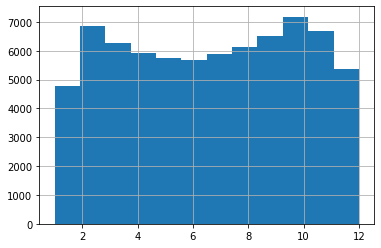

In [7]:
df.Month.hist(bins=12)

Zakupy odbywały się najczęściej w miesiącach jesiennych i wczesnowiosennych, rzadziej latem a najrzadziej na przełomie roku.

In [8]:
df.groupby('Month')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Month,,
3,0.144478,6257
9,0.138842,6511
12,0.133942,5368
1,0.132285,4770
8,0.130477,6139
2,0.130136,6839
4,0.125864,5935
11,0.118652,6675
6,0.111013,5675


Mieszane odczucia - różnica w średnich jest widoczna, szczególnie rzucają się w oczy styczeń i grudzień - jest wtedy również najmniej zakupów, ale mało zakupów jest też latem i średnie są z kolei niskie, kiedy jest najwięcej zakupów - październik, listopad to również mamy niskie średnie. No i wygląda na to że lepiej nie kupować w marcu.

Trzeba będzie pomyśleć czy uwzględniać miesiąc w modelu

<AxesSubplot:>

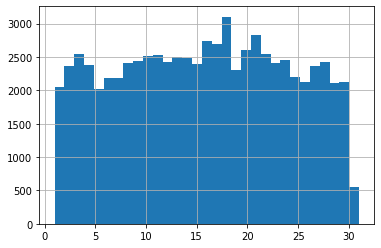

In [9]:
df.Day.hist(bins=31)

In [10]:
df.groupby('Day')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Day,,
31,0.142077,549
3,0.136399,2544
2,0.135249,2366
7,0.133364,2182
1,0.133301,2048
19,0.132812,2304
10,0.132511,2513
30,0.132298,2124
4,0.131127,2387


Z dni nie wynikają żadne interesujące zależności.

**Wnioski: trzeba będzie rozpatrzeć miesiąc jako być może istotną cechę**

## Auction

Identyfikator dostawcy na aukcji, u którego samochód został kupiony

In [11]:
df.groupby('Auction')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Auction,,
ADESA,0.151880,14439
OTHER,0.118165,17501
MANHEIM,0.114880,41043


Jest widoczna pewna zależność - uwzględnimy to

## VehYear

Rok produkcji samochodu

<AxesSubplot:>

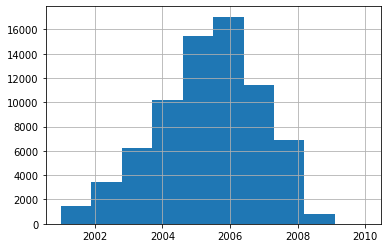

In [12]:
df.VehYear.hist()

In [13]:
df.groupby('VehYear')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
VehYear,,
2001,0.287643,1481
2002,0.240235,3405
2003,0.194315,6227
2004,0.155482,10207
2005,0.131190,15489
2006,0.093880,17043
2007,0.077738,11423
2008,0.055919,6885
2009,0.036496,822


Jest to istotna zmienna z punktu widzenia lemonów.

## VehicleAge

Lata minione od roku produkcji

In [14]:
df.VehYear.corr(df.VehicleAge)

-0.9579570737977844

Bez zaskoczenia, usuniemy zatem rok produkcji, bo wiek samochodu wydaje się sensowniejszą zmienną dla modelu.

## Make

Producent samochodu

In [15]:
df.groupby('Make')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Make,,
CHEVROLET,0.097461,17248
DODGE,0.103237,12912
FORD,0.154091,11305
CHRYSLER,0.128562,8844
PONTIAC,0.119070,4258
KIA,0.117552,2484
SATURN,0.141470,2163
NISSAN,0.159712,2085
HYUNDAI,0.128658,1811


Dość istotna kwestia - trzeba będzie się tym zająć.

## Model

Model samochodu

In [16]:
df.groupby('Model')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Model,,
PT CRUISER,0.187205,2329
IMPALA,0.079899,1990
TAURUS,0.147368,1425
CALIBER,0.104000,1375
CARAVAN GRAND FWD V6,0.121800,1289
...,...,...
TRAILBLAZER 4WD V8,0.000000,1
MONTERO 4WD V6 3.8L,0.000000,1
AVALON 3.0L V6 EFI,0.000000,1


In [17]:
df.groupby(['Make', 'Model'])['IsBadBuy'].agg(['count'])

count
Make       Model                      
ACURA      3.2 CL                    1
           3.2 CL 3.2L V 6 NA S      3
           3.2 TL                    8
           3.2 TL 3.2L V6 EFI        5
           3.2 TL 3.2L V6 FI DO      2
...                                ...
VOLKSWAGEN PASSAT 4C                 1
           RABBIT                    2
           TOUAREG V8                1
VOLVO      S40                      36
           S60                       1

[1066 rows x 1 columns]

## Trim

Rodzaj pakietu

In [18]:
df.Trim.info()

<class 'pandas.core.series.Series'>
RangeIndex: 72983 entries, 0 to 72982
Series name: Trim
Non-Null Count  Dtype 
--------------  ----- 
70623 non-null  object
dtypes: object(1)
memory usage: 570.3+ KB


Występuje tu sporo braków danych.

In [19]:
df.Trim.value_counts()

Bas    13950
LS     10174
SE      9348
SXT     3825
LT      3540
       ...  
Har        1
LL         1
JLX        1
JLS        1
L 3        1
Name: Trim, Length: 134, dtype: int64

In [20]:
df.groupby('Trim')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Trim,,
Bas,0.123799,13950
LS,0.087871,10174
SE,0.122914,9348
SXT,0.098824,3825
LT,0.074859,3540
...,...,...
Har,0.000000,1
LL,0.000000,1
Maz,1.000000,1


Widać tu pewne zależności, ale jest bardzo dużo różnych rodzajów co może sprawić kłopot przy one hot encodingu. Do przemyślenia

## SubModel

Zmienna opisuje liczbę drzwi samochodu, rodzaj nadwozia, pakiet oraz pojemność silnika

In [21]:
df.SubModel.info()

<class 'pandas.core.series.Series'>
RangeIndex: 72983 entries, 0 to 72982
Series name: SubModel
Non-Null Count  Dtype 
--------------  ----- 
72975 non-null  object
dtypes: object(1)
memory usage: 570.3+ KB


Występuje tu całe 8 braków danych. Jakoś sobie chyba z tym poradzimy.

In [22]:
df.groupby('SubModel')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
SubModel,,
4D SEDAN,0.122276,15236
4D SEDAN LS,0.077363,4718
4D SEDAN SE,0.133454,3859
4D WAGON,0.100448,2230
MINIVAN 3.3L,0.099364,1258
...,...,...
4D SUV 4.7L SLT PLUS,0.000000,1
MINIVAN LX,0.000000,1
4D SUV 4.7L FFV LIMITED,0.000000,1


# Preprocessing

## Make

In [23]:
# usuwamy te marki, bo mamy dla nich tylko po 1 lub 2 obserwacje
df = df.loc[~df['Make'].isin(["HUMMER", "PLYMOUTH", "TOYOTA SCION"]), :]

## Month

Tworzymy zmienną pora roku, być może się przyda

In [24]:
# funkcja przypisująca porę roku
def assign_season(df):

    if 3 <= df['Month'] <= 5: val = 'Spring'
    elif 6 <= df['Month'] <= 8: val = 'Summer'
    elif 9 <= df['Month'] <= 11: val = 'Autumn'
    else: val = 'Winter'

    return val

In [25]:
# przypisujemy porę roku
df['Season'] = df.apply(assign_season, axis = 1)
df.groupby('Season')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Season,,
Autumn,0.120666,20362
Spring,0.122723,17951
Summer,0.117298,17690
Winter,0.131951,16976


## SubModel

In [26]:
# wygiągamy liczbę drzwi ze zmiennej SubModel
df['Doors'] = df['SubModel'].str.extract(r'([1-9]D)')
df.groupby('Doors')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Doors,,
4D,0.121753,59826
2D,0.164878,3354
5D,0.229885,87
3D,0.254902,51


In [27]:
df.Doors.isna().sum()

9661

Widać że pojawia się wiele braków, ale zrobimy sobie tu one hot encoder

In [28]:
# wygiągamy pojemność silnika ze zmiennej SubModel
df['Engine_size'] = df['SubModel'].str.extract(r'([1-9].[1-9])')

In [29]:
df.groupby('Engine_size')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Engine_size,,
3.5,0.064031,2858
4.2,0.118615,2369
3.3,0.107420,2318
4.7,0.108478,1899
3.9,0.105839,1096
2.2,0.090149,1076
4.6,0.156532,888
2.7,0.071689,823
3.8,0.199507,812


In [30]:
df.Engine_size.isna().sum()

53430

Fajna sprawa z tą pojemnością, ale za dużo braków danych żeby ją rozpatrywać.

Wyciągnijmy jeszcze rodzaj podwozia ze zmiennej SubModel

In [31]:
df['SubModel_splited'] = df['SubModel'].apply(lambda x: str(x).split())

# funkcja przypisująca rodzaj podwozia
def assign_chassis(df):

    types = ["CAB", "CONVERTIBLE", "CUV", "HATCHBACK", "PASSENGER", "SEDAN", "SPORT", "SUV", "MINIVAN", "UTILITY", "WAGON"]

    for word in df['SubModel_splited']:
        if word in types:
            return word
    return "OTHER"

In [32]:
# tworzymy zmienną Chassis opisującą rodzaj podwozia
df['Chassis'] = df.apply(assign_chassis, axis=1)
df.groupby('Chassis')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Chassis,,
SEDAN,0.115640,42226
SUV,0.135757,8390
WAGON,0.119442,4161
CAB,0.121034,3908
MINIVAN,0.125000,3296
OTHER,0.160136,2935
SPORT,0.147946,2751
PASSENGER,0.127455,2291
CUV,0.124198,1715


## Przetworzenie kolumn kategorycznych

In [33]:
# usuwamy niepotrzebne kolumny
df.drop(['PurchDate', 'VehYear', 'Model', 'Engine_size', 'Year', 'Day', 'SubModel', 'SubModel_splited', 'Trim'], axis=1, inplace=True)

In [34]:
# one hot encoder dla interesujacych nas kolumn
onehot = pdp.OneHotEncode(['Make', 'Chassis', 'Doors', 'Auction', 'Season', 'Month'], drop_first=False)
df = onehot.fit_transform(df)

In [35]:
df

,IsBadBuy,VehicleAge,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,4,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,4,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,1,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
72979,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
72980,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
72981,0,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
